<a href="https://colab.research.google.com/github/saltandpurple/deeplearning-exercises/blob/main/armored_vehicle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ensure basic dependencies are installed
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [ ]:
# download images

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

search_terms = 'mbt','ifv','spaag'
storage_path = Path('armored_vehicle_classification')

for term in search_terms:
    dest = (storage_path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(term))
    #resize_images(storage_path/term, max_size=(400,300), dest=storage_path/term)

failed = verify_images(get_image_files(storage_path))
failed.map(Path.unlink)
len(failed)

Searching for 'mbt'
Searching for 'ifv'
Searching for 'spaag'


1

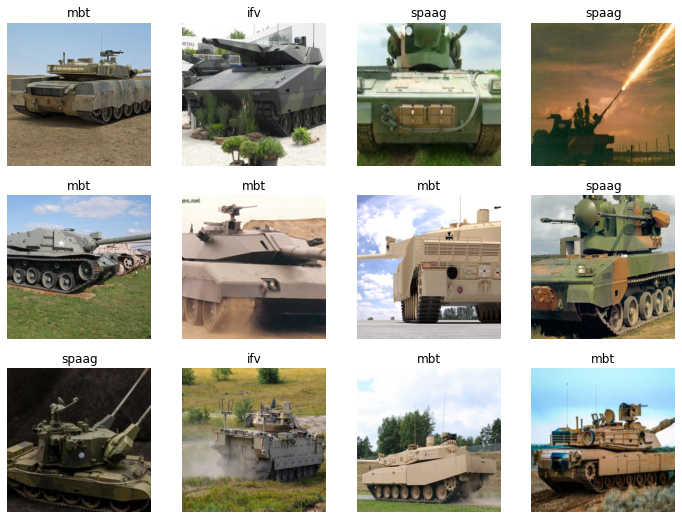

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=31),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(400, min_scale=0.5)]
).dataloaders(storage_path, bs=32)

dls.show_batch(max_n=12)

In [ ]:
learn =  vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.893802,0.830331,0.277108,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.924900,0.485955,0.204819,00:13
1,0.629020,0.374740,0.132530,00:14
2,0.470975,0.351961,0.108434,00:13
3,0.362745,0.367491,0.108434,00:14
4,0.289939,0.321032,0.108434,00:13


Searching for 'spaag'


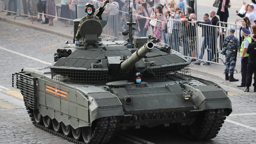

In [ ]:
test_term = 'spaag'
urls = search_images(test_term, max_images=1)

manual_url = 'https://www.19fortyfive.com/wp-content/uploads/2021/12/T-90-1.jpg'
test_image = (test_term + '.jpg')
download_url(manual_url, test_image)
im = Image.open(test_image)
im.to_thumb(256,256)



In [ ]:
kind,_,probs = learn.predict(PILImage.create(test_image))
print(f"This is a: {kind}.")
print(f"Probabilities:\nifv:{probs[0]:.4f}, mbt:{probs[1]:.4f}, spaag:{probs[2]:.4f}")

This is a: mbt.
Probabilities:
ifv:0.1464, mbt:0.4298, spaag:0.4237


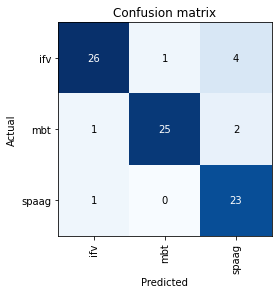

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()